# Model Template

In [2]:
# import necessary packages

import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [3]:
# read data

train_df = pd.read_csv('data/preprocessed_data/train.csv')
val_df = pd.read_csv('data/preprocessed_data/validation.csv')
test_df = pd.read_csv('data/preprocessed_data/test.csv')
corona_df = pd.read_csv('data/preprocessed_data/corona.csv')

In [4]:
# split data

X_train = train_df.drop(columns='count')
y_train = train_df['count']

X_val = val_df.drop(columns='count')
y_val = val_df['count']

X_test = test_df.drop(columns='count')
y_test = test_df['count']

X_corona = corona_df.drop(columns='count')
y_corona = corona_df['count']

In [6]:
# hyperparameter tuning

try:
    hyperparameters_df = pd.read_csv('data/hyperparameter_tuning/xgboost.csv')
    
except FileNotFoundError:
    
    # df containing hyperparameters and evaluation metrics of each run
    hyperparameters_df = pd.DataFrame()
    
    # this function is used by optuna to tune the hyperparameters
    def objective(trial):
        # define hyperparameters
        colsample_bynode = trial.suggest_float('colsample_bynode', 0.01, 1)
        max_depth = trial.suggest_int('max_depth', 1, 10)
        subsample = trial.suggest_float('subsample', 0.01, 1)
        n_estimators = trial.suggest_int('n_estimators', 1, 200)
        gamma = trial.suggest_float('gamma', 0.0, 20.0)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
        
        # setup and train model
        xgb_reg = XGBRegressor(
            colsample_bynode=colsample_bynode,            
            max_depth=max_depth,
            subsample=subsample,
            n_estimators=n_estimators,
            gamma=gamma,
            learning_rate=learning_rate,
        )
        xgb_reg.fit(X_train, y_train)
        
        # make predictions
        y_val_pred = xgb_reg.predict(X_val)
        
        # evaluate predictions
        r_squared = r2_score(y_val, y_val_pred)
        rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
        
        # insert results in dataframe
        global hyperparameters_df
        hyperparameters_df = hyperparameters_df.append(
            {'colsample_bynode': colsample_bynode,
             'max_depth': max_depth,
             'subsample': subsample,
             'n_estimators': n_estimators,
             'gamma': gamma,
             'learning_rate': learning_rate,
             'r_squared': r_squared,
             'rmse': rmse},
            ignore_index=True
        )
        
        # return rmse -> optuna will optimize rmse
        return rmse
        
        
    study = optuna.create_study()
    # start optimization
    study.optimize(objective, n_trials=25)
    
    # convert to correct data types
    hyperparameters_df[['n_estimators', 'max_depth']] = hyperparameters_df[['n_estimators', 'max_depth']].astype('int')
    
    # sort hyperparameter tuning results and save file
    hyperparameters_df = hyperparameters_df.sort_values('rmse', ascending=True)
    hyperparameters_df = hyperparameters_df.reset_index(drop=True)
    hyperparameters_df.to_csv('data/hyperparameter_tuning/xgboost.csv', index=False)

In [7]:
hyperparameters_df.head()

,colsample_bynode,max_depth,subsample,n_estimators,gamma,learning_rate,r_squared,rmse
0,0.437476,9,0.873376,194,17.070415,0.305039,0.766170,12.690887
1,0.656197,9,0.864334,199,14.695009,0.165400,0.762414,12.792402
2,0.266017,9,0.767387,158,13.876090,0.207275,0.760452,12.845108
3,0.382525,8,0.816739,170,15.633954,0.183202,0.759579,12.868489
4,0.842880,9,0.711444,181,18.129390,0.120066,0.756722,12.944731


In [8]:
# build final model on test and validation data

X_final_train = pd.concat([X_train, X_val], ignore_index=True)
y_final_train = pd.concat([y_train, y_val], ignore_index=True)

In [9]:
# final model evaluation

# build and train model using the most successful hyperparameters
xgb_reg = XGBRegressor(
    colsample_bynode=hyperparameters_df.loc[0, 'colsample_bynode'],            
    max_depth=hyperparameters_df.loc[0, 'max_depth'],
    subsample=hyperparameters_df.loc[0, 'subsample'],
    n_estimators=hyperparameters_df.loc[0, 'n_estimators'],
    gamma=hyperparameters_df.loc[0, 'gamma'],
    learning_rate=hyperparameters_df.loc[0, 'learning_rate'],
)
xgb_reg.fit(X_final_train, y_final_train)

# make predictions
y_test_pred = xgb_reg.predict(X_test)

# evaluate predictions
r_squared = r2_score(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5

print(f'R^2:\t{r_squared}')
print(f'RMSE:\t{rmse}')

R^2:	0.7220409286287315
RMSE:	14.02063809686226


In [10]:
# predictions on corona year 2020

# make predictions
y_corona_pred = xgb_reg.predict(X_corona)

# evaluate predictions
r_squared_c = r2_score(y_corona, y_corona_pred)
rmse_c = mean_squared_error(y_corona, y_corona_pred) ** 0.5

print(f'R^2:\t{r_squared_c}')
print(f'RMSE:\t{rmse_c}')

R^2:	-0.5608275777002061
RMSE:	19.55826570953334


In [11]:
# predictions for stations

df_all = pd.concat(
    map(pd.read_csv, ["data/preprocessed_data/corona.csv",
                      "data/preprocessed_data/test.csv",
                     "data/preprocessed_data/train.csv",
                     "data/preprocessed_data/validation.csv"]
       ), ignore_index=True)

stations = pd.read_csv('data/stations_preprocessed/Stations_2019.csv')

df_all

,latitude,longitude,distance_to_center,year,month,weekday,pm,holiday,mean_temperature,total_precipitation,stations_count,elevation_meters,density,count
0,45.549598,-73.541874,5.530209,2020,4,2,0,False,2.2,0.0,609,21,13,1
1,45.549598,-73.541874,5.530209,2020,4,2,1,False,2.2,0.0,609,21,13,6
2,45.510351,-73.556508,1.219082,2020,4,2,0,False,2.2,0.0,609,13,34,1
3,45.510351,-73.556508,1.219082,2020,4,2,1,False,2.2,0.0,609,13,34,15
4,45.539385,-73.541000,4.532643,2020,4,2,0,False,2.2,0.0,609,16,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384468,45.499745,-73.579034,0.903139,2018,10,2,0,False,2.4,8.2,549,54,41,11
1384469,45.499745,-73.579034,0.903139,2018,10,2,1,False,2.4,8.2,549,54,41,5
1384470,45.512832,-73.576888,1.210305,2018,10,2,0,False,2.4,8.2,549,53,45,8
1384471,45.512832,-73.576888,1.210305,2018,10,2,1,False,2.4,8.2,549,53,45,6


In [12]:
# predictions for stations

df_all = pd.concat(
    map(pd.read_csv, ["data/preprocessed_data/corona.csv",
                      "data/preprocessed_data/test.csv",
                     "data/preprocessed_data/train.csv",
                     "data/preprocessed_data/validation.csv"]
       ), ignore_index=True)

stations = pd.read_csv('data/stations_preprocessed/Stations_2019.csv')

df_all = pd.merge(df_all,stations[['latitude','Code']],on='latitude', how='left')


# get one big and one small station
display(df_all["Code"].value_counts().head())
display(df_all["Code"].value_counts().tail(100))

#filter df for these two stations
df_station6184 = df_all[(df_all["Code"] == 6184.0)]
df_station7112 = df_all[(df_all["Code"] == 7036.0)]

df_stationpred = pd.concat([df_station6184, df_station7112])
df_stationpred.drop(columns='Code')

display(df_stationpred)

6114.0    2811
6175.0    2811
6206.0    2811
6184.0    2810
6248.0    2810
Name: Code, dtype: int64

7036.0    1495
7047.0    1490
7029.0    1484
5002.0    1481
5004.0    1480
          ... 
7152.0     221
7086.0     220
7088.0     201
7089.0     160
7085.0      88
Name: Code, Length: 100, dtype: int64

,latitude,longitude,distance_to_center,year,month,weekday,pm,holiday,mean_temperature,total_precipitation,stations_count,elevation_meters,density,count,Code
209,45.524673,-73.582550,2.581618,2020,4,2,0,False,2.2,0.0,609,51,54,2,6184.0
210,45.524673,-73.582550,2.581618,2020,4,2,1,False,2.2,0.0,609,51,54,11,6184.0
972,45.524673,-73.582550,2.581618,2020,4,3,0,False,1.1,0.2,609,51,54,3,6184.0
973,45.524673,-73.582550,2.581618,2020,4,3,1,False,1.1,0.2,609,51,54,12,6184.0
1795,45.524673,-73.582550,2.581618,2020,4,4,0,False,1.4,0.0,609,51,54,6,6184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382344,45.519895,-73.596827,2.841367,2018,10,0,1,False,4.5,1.4,549,74,27,16,7036.0
1383369,45.519895,-73.596827,2.841367,2018,10,1,0,False,2.1,0.0,549,74,27,13,7036.0
1383370,45.519895,-73.596827,2.841367,2018,10,1,1,False,2.1,0.0,549,74,27,14,7036.0
1384369,45.519895,-73.596827,2.841367,2018,10,2,0,False,2.4,8.2,549,74,27,12,7036.0


In [13]:
# predictions on stations 6184 and 7036

X_df_stationpred = df_stationpred.drop(columns=['count', 'Code'])
y_df_stationpred = df_stationpred['count']

# make predictions
y_stations_pred = xgb_reg.predict(X_df_stationpred)

# evaluate predictions
r_squared_c = r2_score(y_df_stationpred, y_stations_pred)
rmse_c = mean_squared_error(y_df_stationpred, y_stations_pred) ** 0.5

print(f'R^2:\t{r_squared_c}')
print(f'RMSE:\t{rmse_c}')

X_stations_comparison = X_df_stationpred.assign(count=y_df_stationpred)
X_stations_comparison = X_stations_comparison.assign(prediction=y_stations_pred)

R^2:	0.858829931047783
RMSE:	23.28626692181471


In [14]:
X_stations_comparison["latitude"].value_counts()

45.524673    2810
45.519895    1495
Name: latitude, dtype: int64

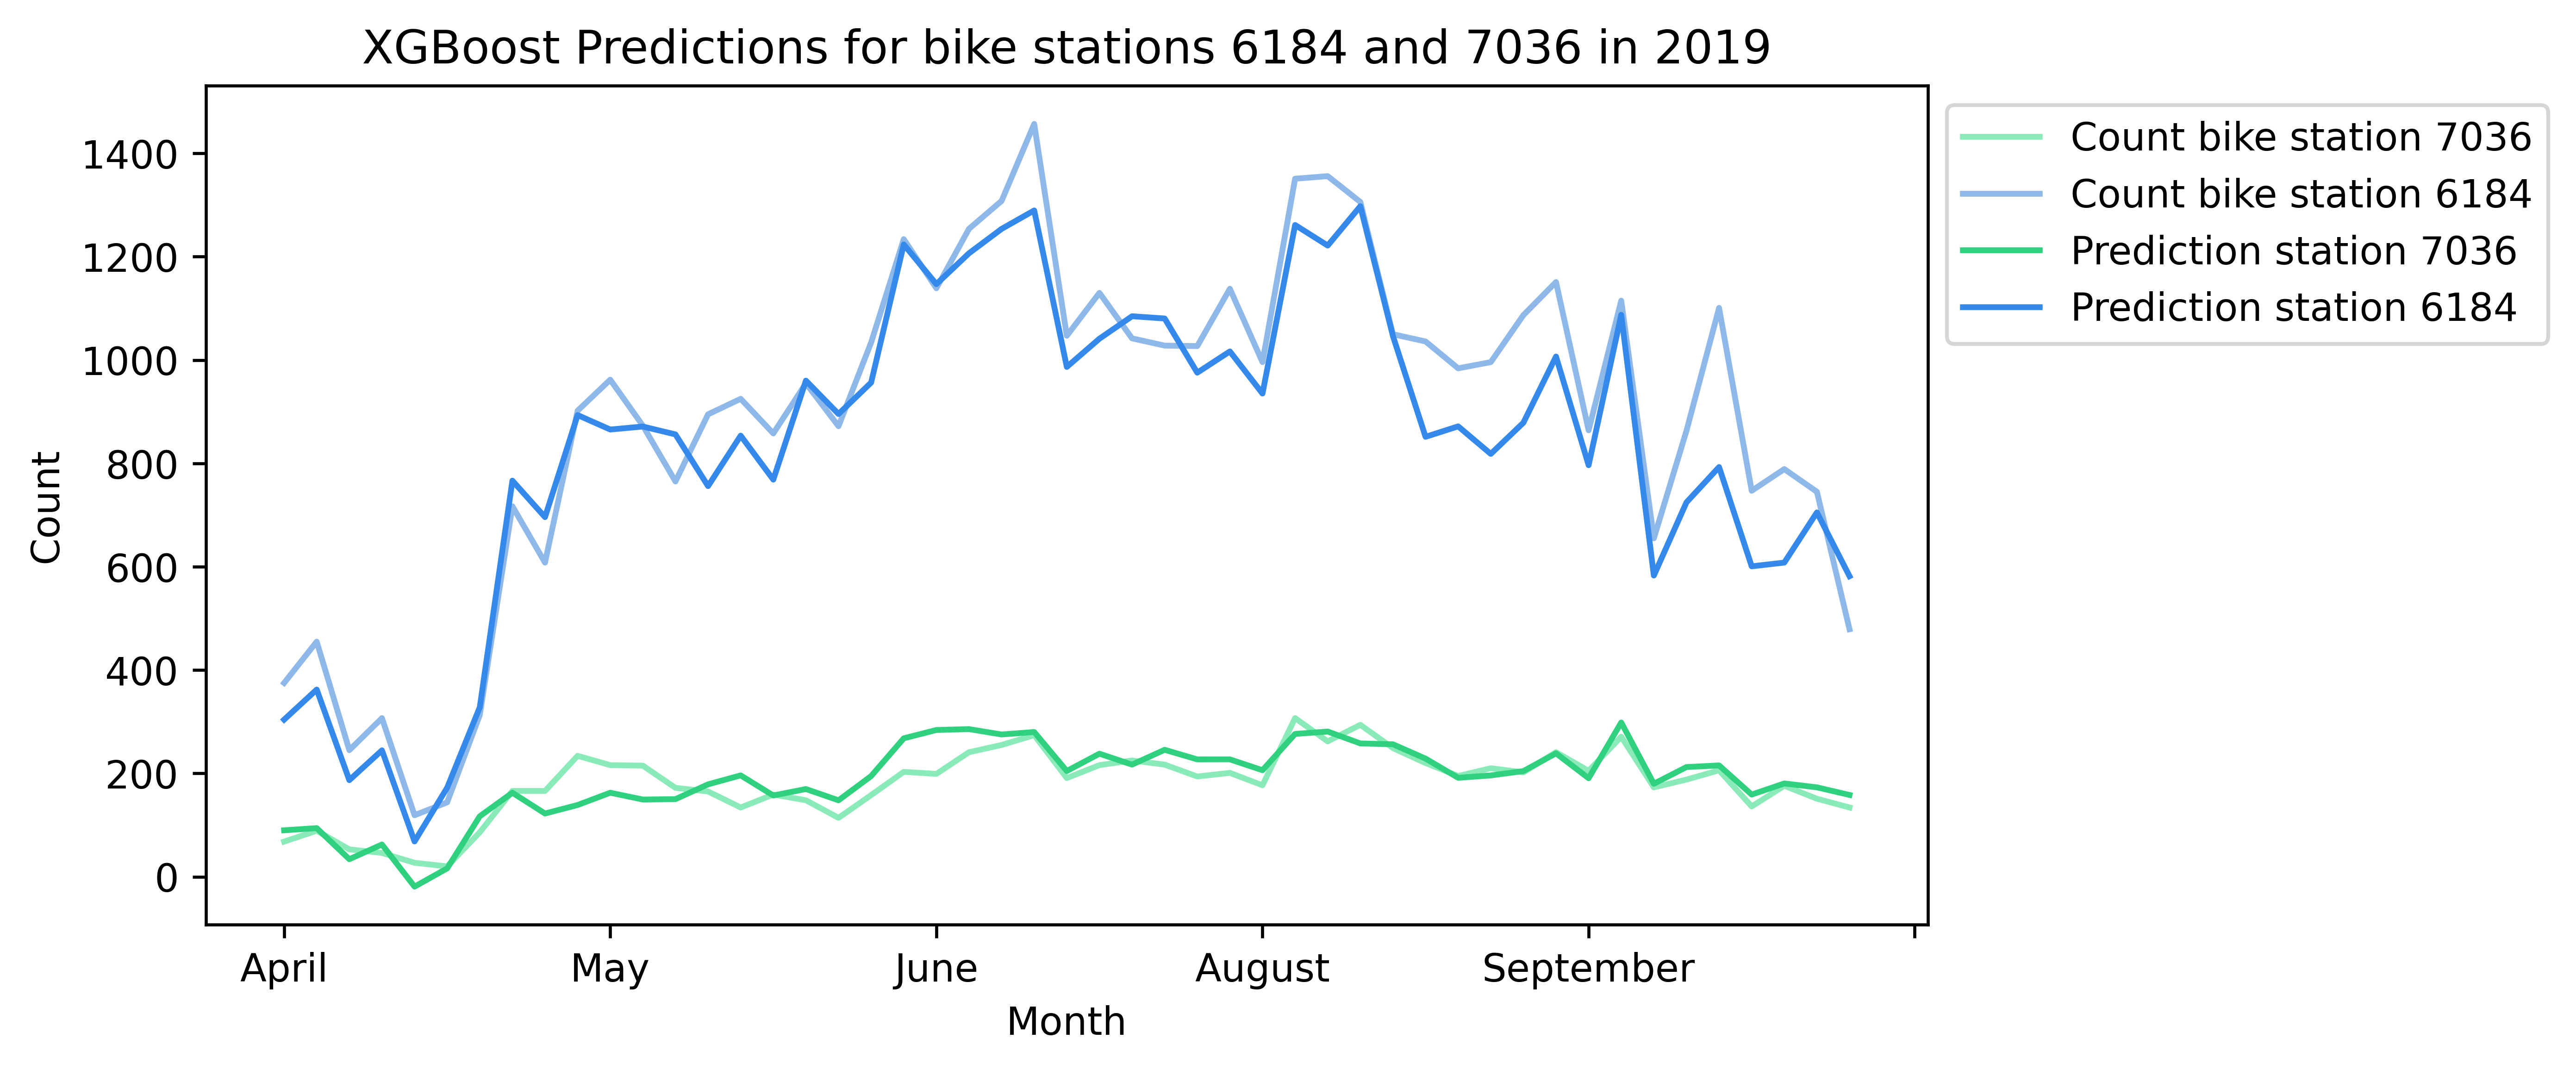

In [23]:
# Plots
plt.rcParams['figure.dpi'] = 600

fig, ax = plt.subplots(figsize=(8, 4))

X_stations_group = X_stations_comparison[X_stations_comparison['year'] == 2019].groupby([pd.Grouper(key='month'), 'latitude', 'weekday'])[["count", "prediction"]].sum().unstack('latitude')

X_stations_group.head(30)

X_stations_group.plot(kind='line', ax=ax, title="XGBoost Predictions for bike stations 6184 and 7036 in 2019", xlabel="Month", ylabel="Count",
                      color=['#8aebb9', '#8eb8e8', '#30d17e', '#3489eb'])

ax.set_xticklabels(["", "April", "May", "June", "August", "September", "", ""])
ax.legend(["Count bike station 7036", "Count bike station 6184", "Prediction station 7036", "Prediction station 6184"], bbox_to_anchor=(1, 1))


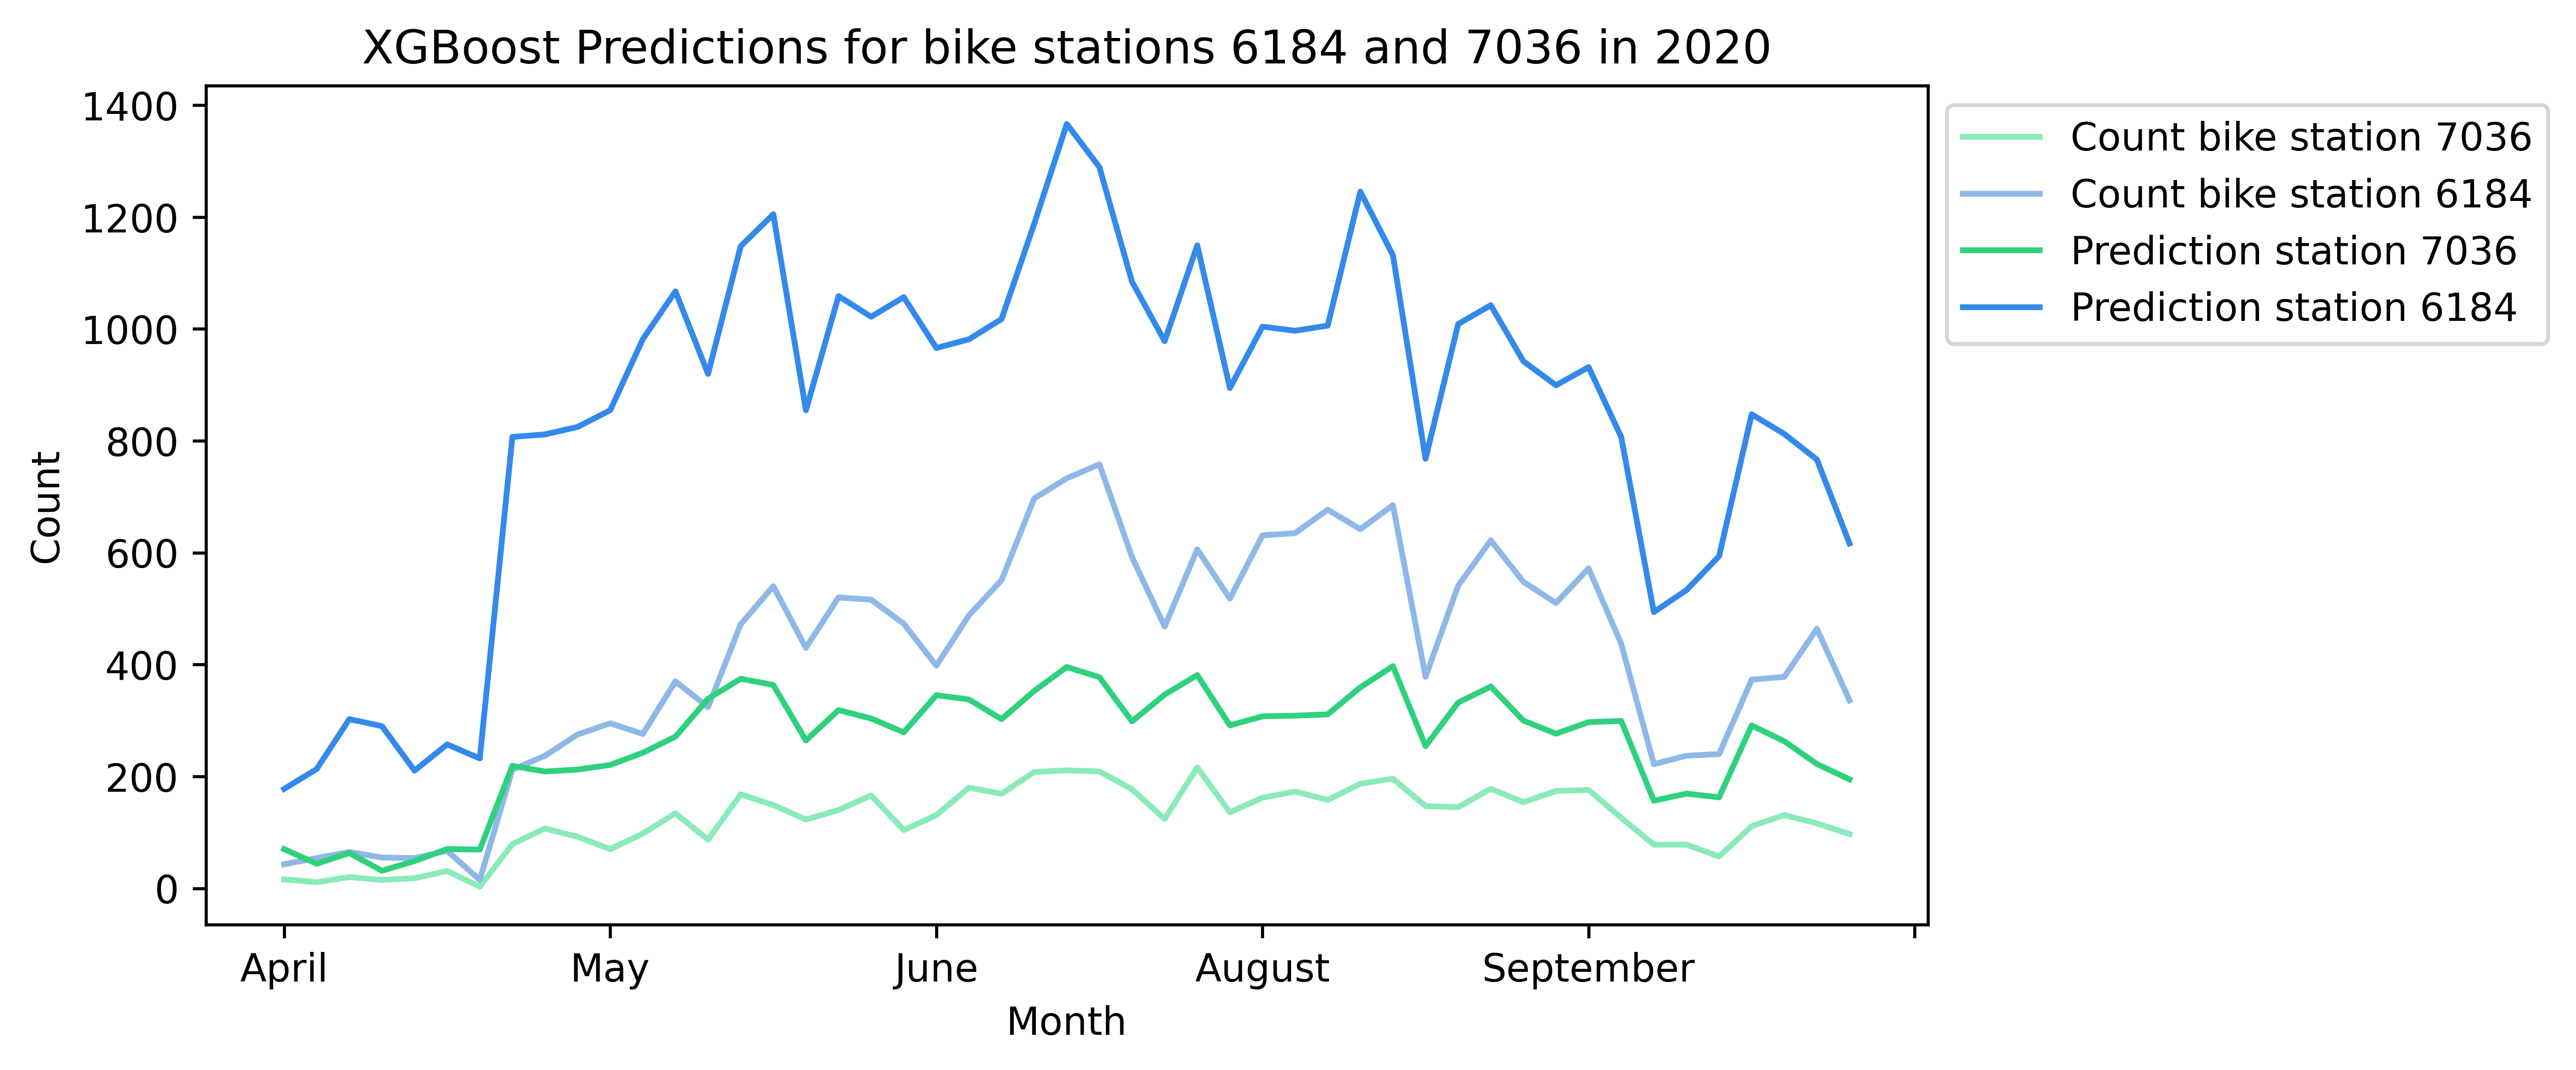

In [22]:
# Plots
plt.rcParams['figure.dpi'] = 600

fig, ax = plt.subplots(figsize=(8, 4))

X_stations_group = X_stations_comparison[X_stations_comparison['year'] == 2020].groupby([pd.Grouper(key='month'), 'latitude', 'weekday'])[["count", "prediction"]].sum().unstack('latitude')

X_stations_group.head(30)

X_stations_group.plot(kind='line', ax=ax, title="XGBoost Predictions for bike stations 6184 and 7036 in 2020", xlabel="Month", ylabel="Count",
                      color=['#8aebb9', '#8eb8e8', '#30d17e', '#3489eb'])

ax.set_xticklabels(["", "April", "May", "June", "August", "September", "", ""])
ax.legend(["Count bike station 7036", "Count bike station 6184", "Prediction station 7036", "Prediction station 6184"], bbox_to_anchor=(1, 1))